# 3.3.4 Challenge:  Advanced Regression - Crime Data

__Goal:__ Engineer features and create three models: 1. Vanilla logistic regression. 2. Ridge logistic regression. 3. Lasso logistic regression.  Evaluate the models and decide on the best model for the dataset. 

__Source:__ Colorado crime data from 2013 as provided by the [FBI: UCR](https://ucr.fbi.gov/crime-in-the-u.s/2013/crime-in-the-u.s.-2013/tables/table-8/table-8-state-cuts/table_8_offenses_known_to_law_enforcement_colorado_by_city_2013.xls)

In [1]:
#necessary imports
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import scale
from scipy.stats import ttest_ind
import statsmodels.api as sm
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', module='scipy', message='^internal gelsd')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Cleaning Data

In [2]:
#read in data
crime = pd.read_excel('table_8_offenses_known_to_law_enforcement_colorado_by_city_2013.xls', header=4)
crime.head()

,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson
0,Arvada,110792.0,163.0,0.0,33.0,NaN,34.0,96.0,2666.0,331.0,2138.0,197.0,22.0
1,Aspen,6685.0,14.0,0.0,5.0,NaN,0.0,9.0,314.0,17.0,286.0,11.0,0.0
2,Ault,1565.0,0.0,0.0,0.0,NaN,0.0,0.0,2.0,0.0,0.0,2.0,0.0
3,Aurora,343484.0,1436.0,23.0,224.0,NaN,468.0,721.0,10786.0,1981.0,7805.0,1000.0,80.0
4,Avon,6336.0,9.0,0.0,3.0,NaN,0.0,6.0,140.0,12.0,124.0,4.0,1.0


__Data Set Description:__ This data set includes city populations for all cities in Colorado.  For each city, the following information is also reported: number of violent crimes reported in the city, number of murders, rapes, robberies, aggravated assault, property crimes, burglaries, larceny-thefts, motor vehicle thefts, and arson. 

In [3]:
print(len(crime))
crime.isnull().sum()

137


City                                        0
Population                                  2
Violent\ncrime                              2
Murder and\nnonnegligent\nmanslaughter      2
Rape\n(revised\ndefinition)1                2
Rape\n(legacy\ndefinition)2               137
Robbery                                     2
Aggravated\nassault                         2
Property\ncrime                             2
Burglary                                    2
Larceny-\ntheft                             2
Motor\nvehicle\ntheft                       2
Arson                                       2
dtype: int64

Because the legacy definition of rape was revised in 2013, all instances of rape were recorded in the revised definition count. For this reason, we can drop the column containing the legacy definition.

In [4]:
#cleaning up column names
crime = crime.rename(columns={'Violent\ncrime': 'violent_crime', 
                              'Murder and\nnonnegligent\nmanslaughter': 'murder', 
                              'Rape\n(revised\ndefinition)1': 'rape1', 
                              'Rape\n(legacy\ndefinition)2':'rape2',
                              'Aggravated\nassault': 'assault', 
                              'Property\ncrime': 'property_crime',
                              'Larceny-\ntheft': 'larceny', 
                              'Motor\nvehicle\ntheft': 'mv_theft',
                              'Arson': 'arson'})


#dropping the legacy definition of rape
crime = crime.drop('rape2', axis=1)
crime.tail()

,City,Population,violent_crime,murder,rape1,Robbery,assault,property_crime,Burglary,larceny,mv_theft,arson
132,Woodland Park,7185.0,10.0,0.0,2.0,0.0,8.0,195.0,11.0,179.0,5.0,2.0
133,Wray,2373.0,1.0,0.0,0.0,0.0,1.0,4.0,0.0,4.0,0.0,0.0
134,Yuma,3563.0,2.0,0.0,1.0,0.0,1.0,16.0,1.0,14.0,1.0,0.0
135,1 The figures shown in this column for the off...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
136,2 The figures shown in this column for the off...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In inspecting the tail of the data set, the last two rows contain summary information, and can be dropped.  This will remove 100% of the missing values.

In [5]:
#dropping NA values
crime = crime.dropna()

### Exploring the Data

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


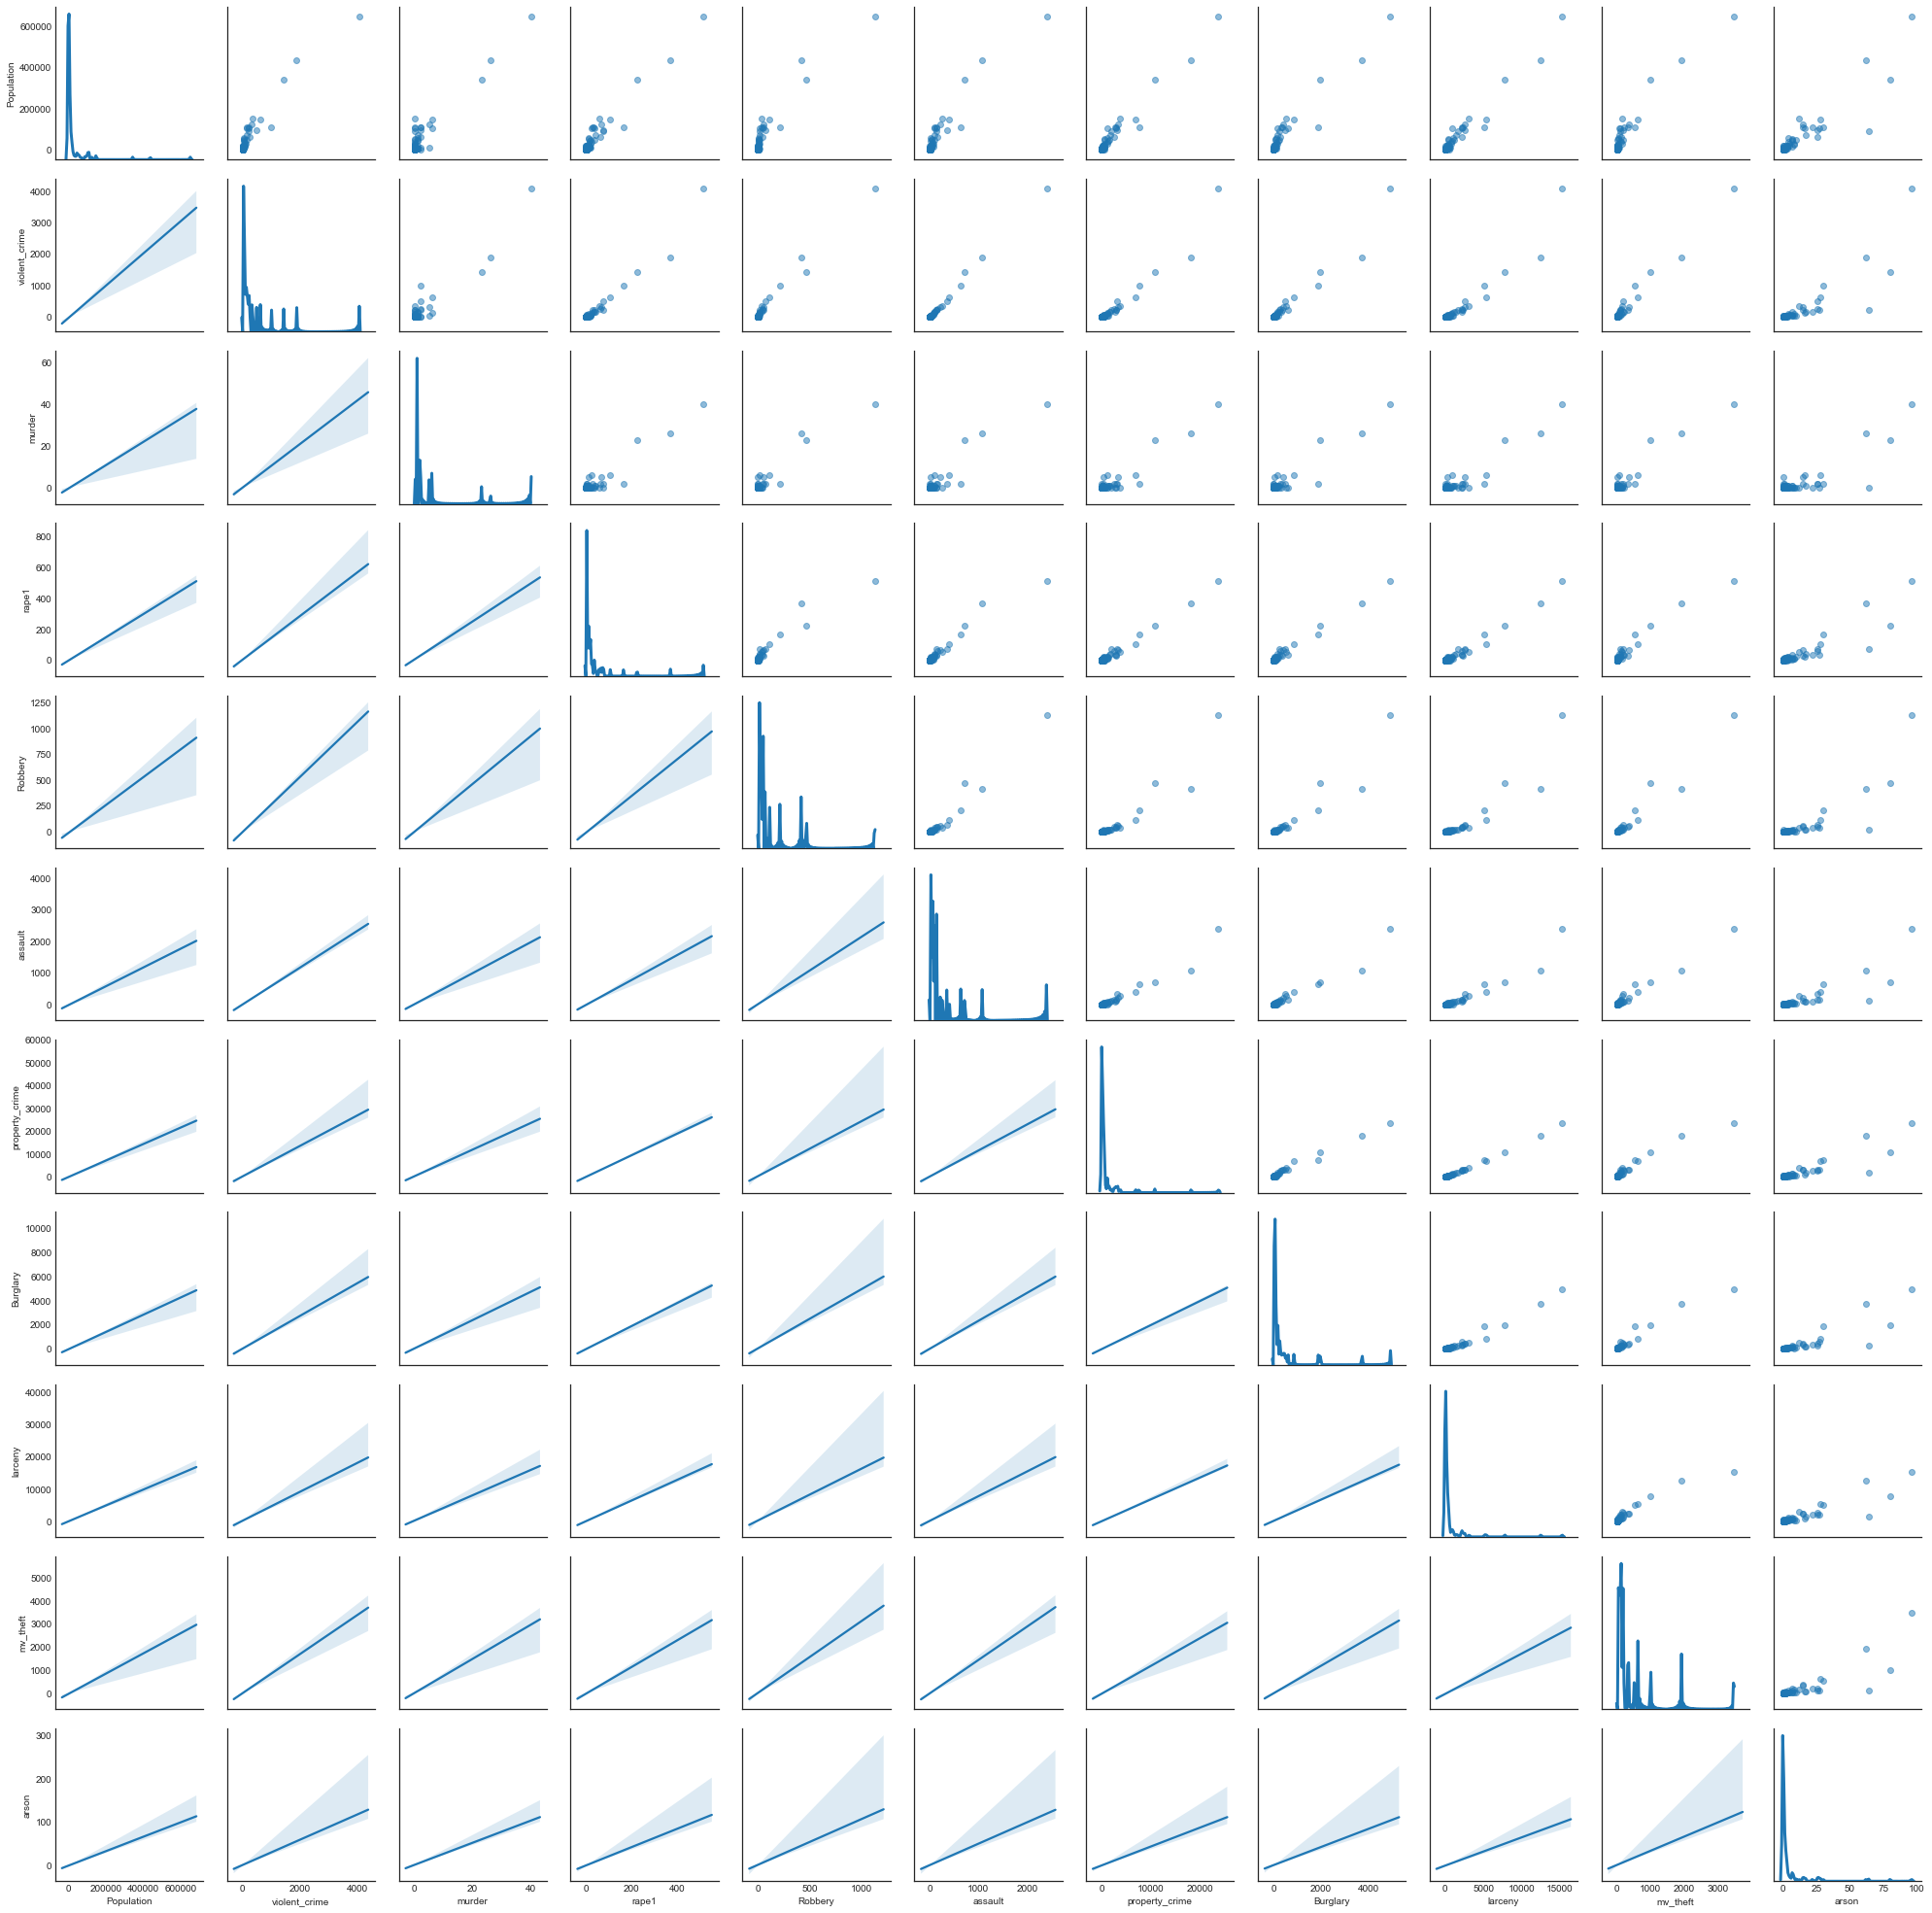

In [6]:
sns.set_style('white')

g = sns.PairGrid(crime, diag_sharey=False)
g.map_upper(plt.scatter, alpha=0.5)
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))
g.map_diag(sns.kdeplot, lw=3)
plt.show()

From these scatter plots and lines of linear regression, it is clear that there is a large number of cities with crime counts around zero, and the populations of cities are also clustered around lower counts with a small number of larger cities.  The data also shows that cities with larger populations have larger counts of other crimes. To better visualize theae correlations, I will create a heat map.

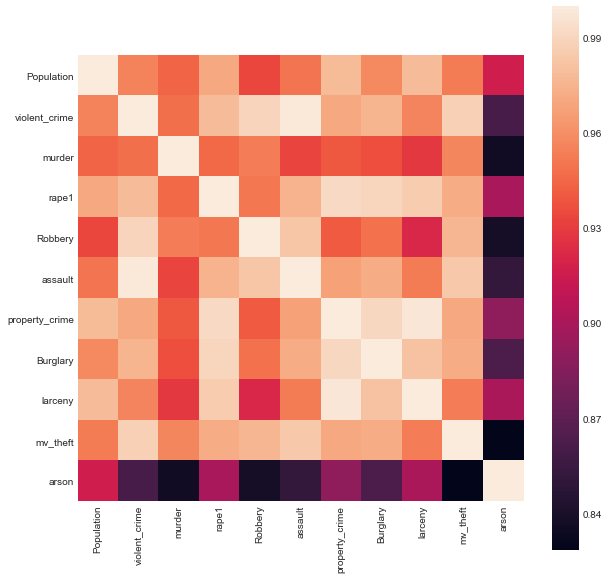

,Population,violent_crime,murder,rape1,Robbery,assault,property_crime,Burglary,larceny,mv_theft,arson
Population,1.000000,0.955509,0.943857,0.970261,0.933657,0.950147,0.978446,0.958378,0.978807,0.952703,0.916691
violent_crime,0.955509,1.000000,0.948151,0.978862,0.989855,0.998320,0.970560,0.975267,0.955814,0.987394,0.860894
murder,0.943857,0.948151,1.000000,0.945837,0.953402,0.933379,0.940282,0.936824,0.928407,0.956460,0.836128
rape1,0.970261,0.978862,0.945837,1.000000,0.951520,0.974564,0.991829,0.990488,0.985384,0.972026,0.900030
Robbery,0.933657,0.989855,0.953402,0.951520,1.000000,0.982893,0.940553,0.948940,0.921530,0.976445,0.838057
assault,0.950147,0.998320,0.933379,0.974564,0.982893,1.000000,0.967515,0.972114,0.952820,0.984418,0.851383
property_crime,0.978446,0.970560,0.940282,0.991829,0.940553,0.967515,1.000000,0.991075,0.997622,0.969868,0.890076
Burglary,0.958378,0.975267,0.936824,0.990488,0.948940,0.972114,0.991075,1.000000,0.981455,0.971962,0.862739
larceny,0.978807,0.955814,0.928407,0.985384,0.921530,0.952820,0.997622,0.981455,1.000000,0.953465,0.900130
mv_theft,0.952703,0.987394,0.956460,0.972026,0.976445,0.984418,0.969868,0.971962,0.953465,1.000000,0.828402


In [7]:
corrmat = crime.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corrmat, square=True)
plt.show()

corrmat

It is clear that there is a good amount of correlation between the different variables.  This is to be expected because violent crime and property crime are both calculated based on the number of respective types of crime.  The only varible that is somewhat independent is arson. 

### Feature Engineering
In accordance with the data exploration, larger populations have larger counts of other crimes, which makes sense.  In other reports of crime, it is customary to report crimes per capita, so I will make features per capita and examine that data.

In [8]:
#creating a data frame to hold per 1000 residents features by city, while still including the population of the city
crime_per_cap = pd.DataFrame()
crime_per_cap['City'] = crime['City']
crime_per_cap['Population'] = crime['Population']

for col in crime.drop(['City', 'Population'], axis=1):
    crime_per_cap[col] = crime[col]/crime['Population']*1000

crime_per_cap.head()

,City,Population,violent_crime,murder,rape1,Robbery,assault,property_crime,Burglary,larceny,mv_theft,arson
0,Arvada,110792.0,1.471225,0.000000,0.297855,0.306881,0.866489,24.063109,2.987580,19.297422,1.778107,0.198570
1,Aspen,6685.0,2.094241,0.000000,0.747943,0.000000,1.346298,46.970830,2.543007,42.782349,1.645475,0.000000
2,Ault,1565.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.277955,0.000000,0.000000,1.277955,0.000000
3,Aurora,343484.0,4.180690,0.066961,0.652141,1.362509,2.099079,31.401754,5.767372,22.723038,2.911344,0.232908
4,Avon,6336.0,1.420455,0.000000,0.473485,0.000000,0.946970,22.095960,1.893939,19.570707,0.631313,0.157828


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


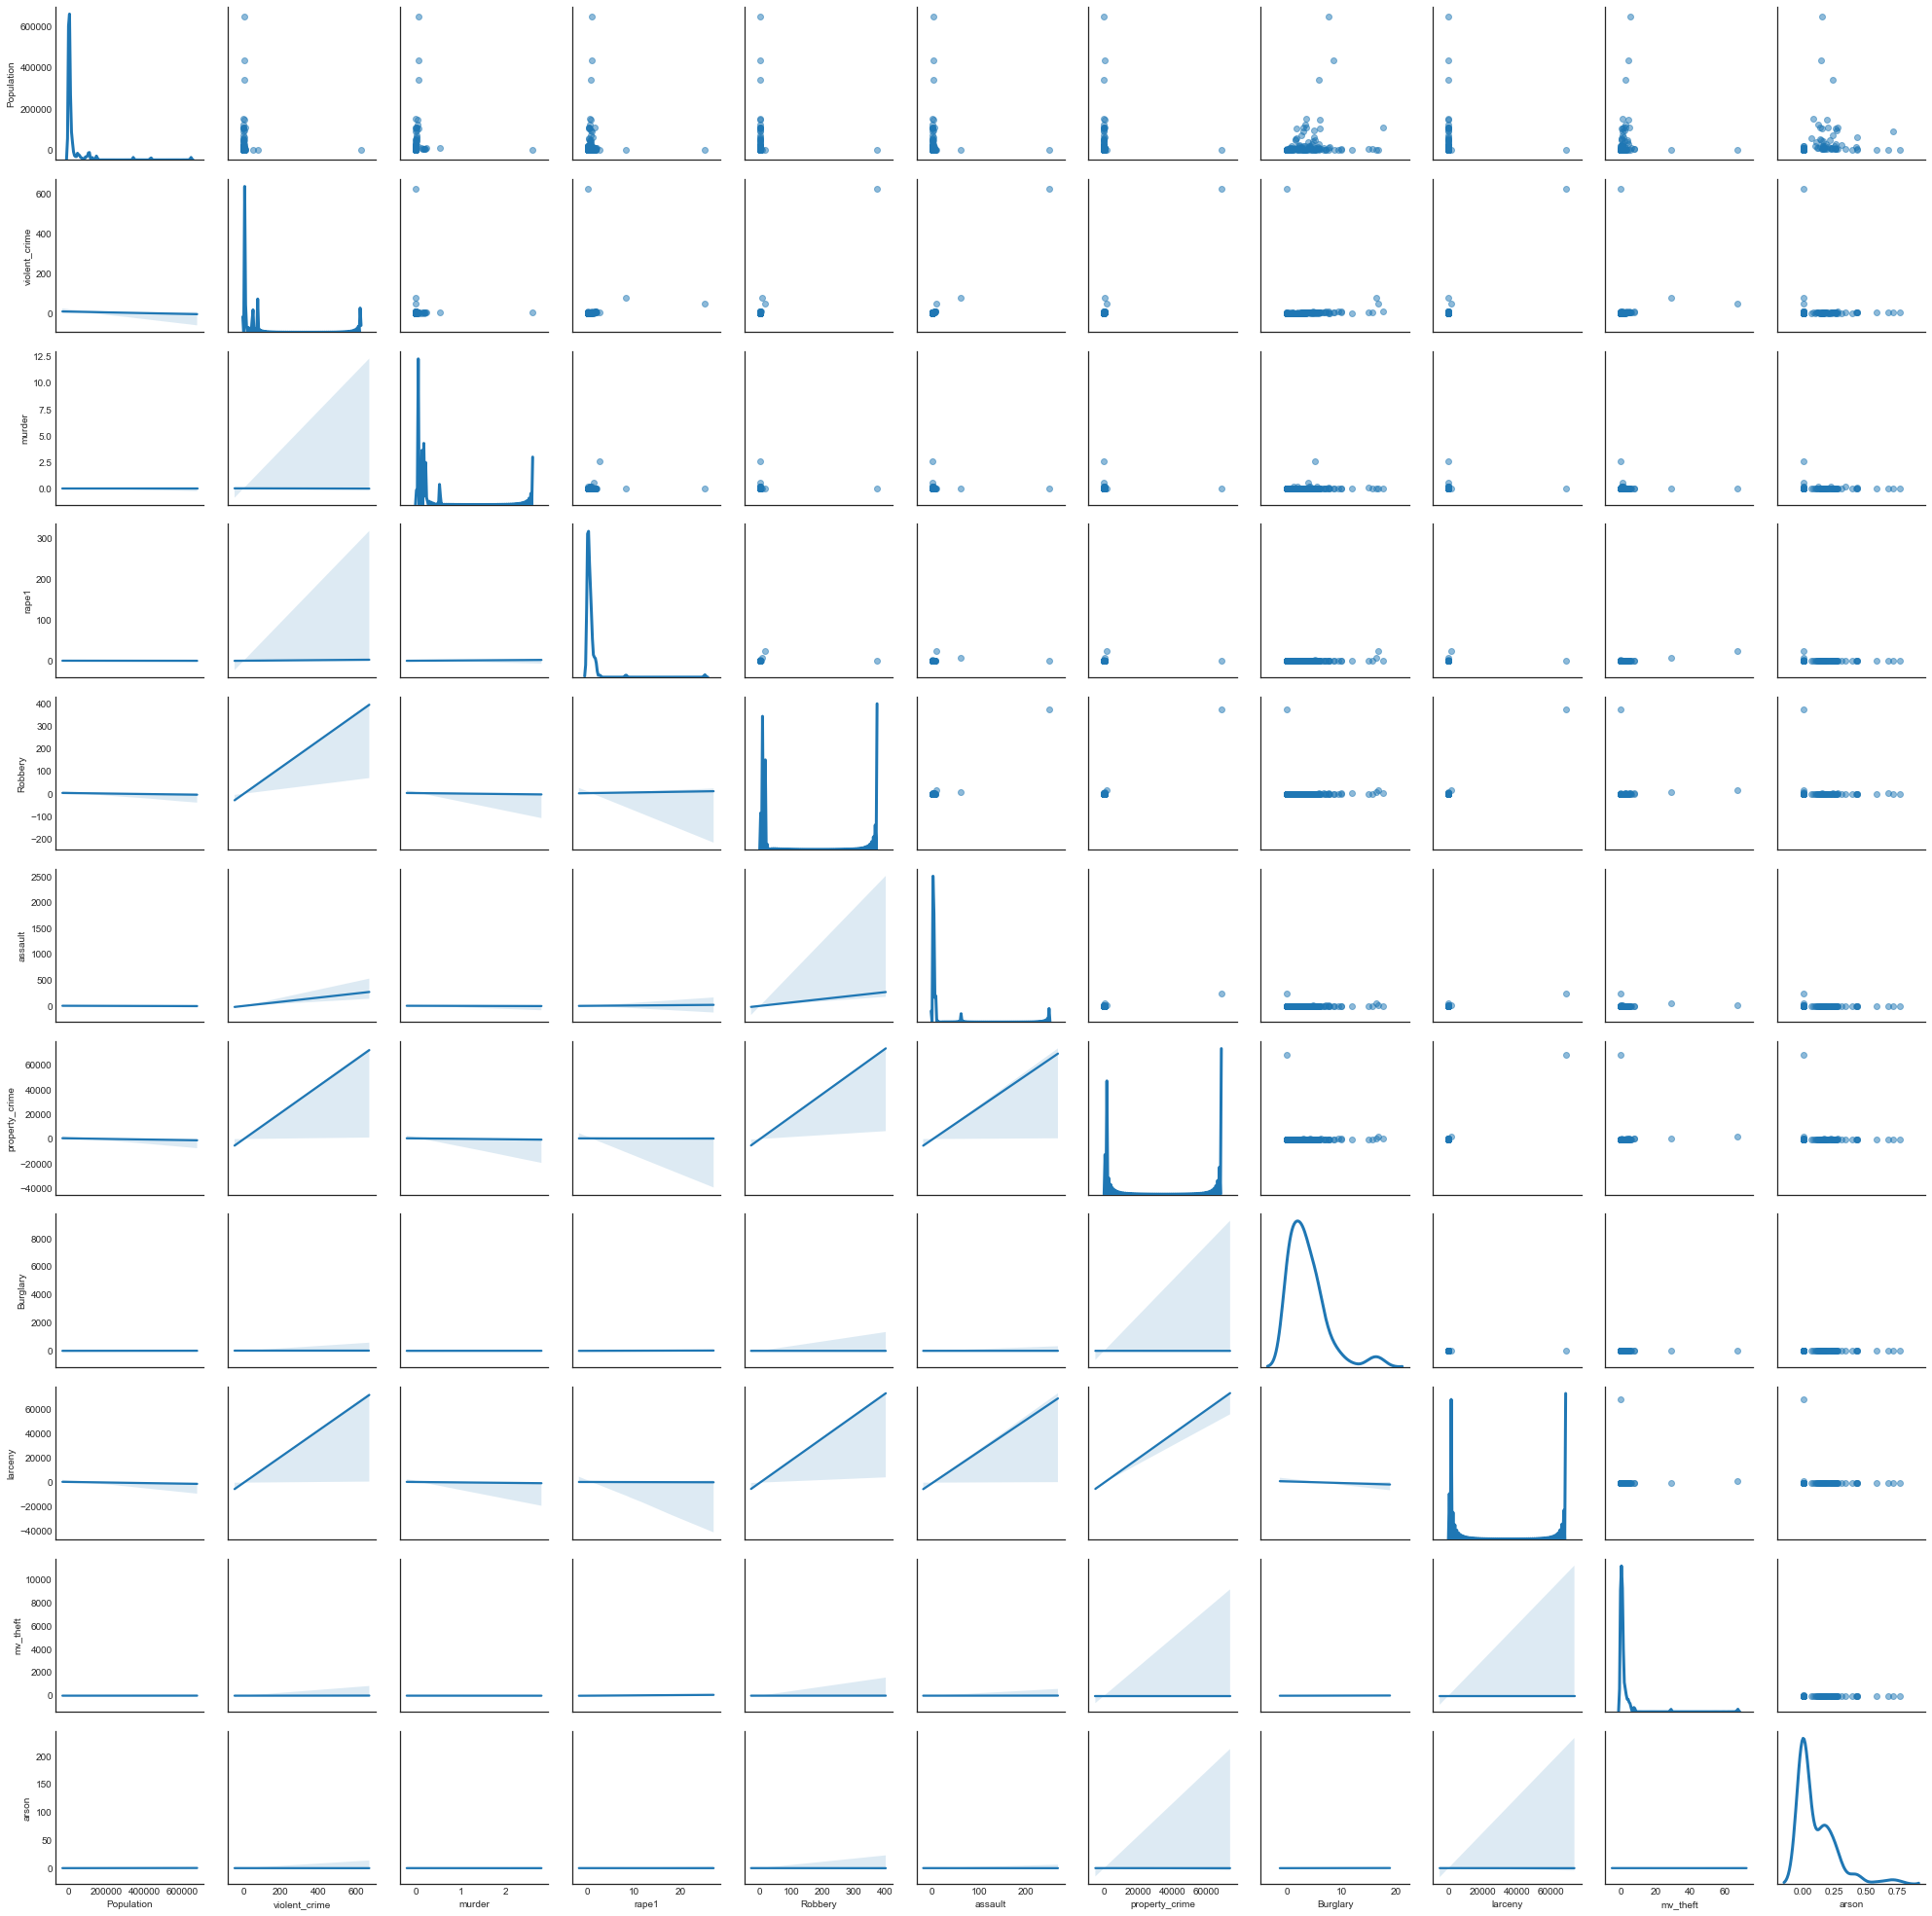

In [9]:
#creating pair grid to inspect relationships between data per capita
g = sns.PairGrid(crime_per_cap, diag_sharey=False)
g.map_upper(plt.scatter, alpha=0.5)
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))
g.map_diag(sns.kdeplot, lw=3)
plt.show()

This transformation evens out the data to eliminate some of the correlation between variables and turns outliers into more usable information. Let's inspect the correlations through a heat map to identify variables that are not correlated to each other.

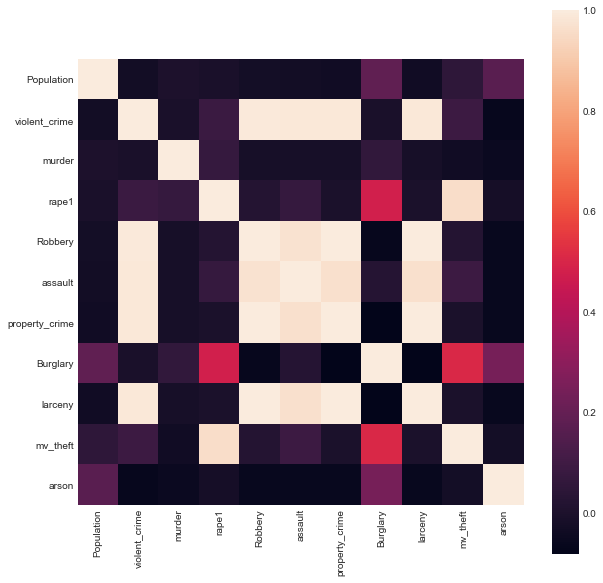

,Population,violent_crime,murder,rape1,Robbery,assault,property_crime,Burglary,larceny,mv_theft,arson
Population,1.000000e+00,-0.027409,-6.250187e-07,-0.008810,-0.026367,-0.027776,-0.030731,0.185072,-0.030898,0.053588,0.171419
violent_crime,-2.740864e-02,1.000000,-8.943984e-03,0.085545,0.993964,0.991177,0.990888,-0.006379,0.990742,0.091329,-0.060207
murder,-6.250187e-07,-0.008944,1.000000e+00,0.070911,-0.015294,-0.017358,-0.014130,0.059598,-0.014132,-0.031058,-0.047778
rape1,-8.809791e-03,0.085545,7.091142e-02,1.000000,0.022380,0.072684,-0.001981,0.478370,-0.003299,0.960068,-0.021363
Robbery,-2.636744e-02,0.993964,-1.529431e-02,0.022380,1.000000,0.974129,0.999520,-0.061973,0.999480,0.023114,-0.059761
assault,-2.777598e-02,0.991177,-1.735792e-02,0.072684,0.974129,1.000000,0.969795,0.024824,0.969631,0.091035,-0.057607
property_crime,-3.073079e-02,0.990888,-1.412993e-02,-0.001981,0.999520,0.969795,1.000000,-0.080142,0.999999,-0.003054,-0.059708
Burglary,1.850715e-01,-0.006379,5.959759e-02,0.478370,-0.061973,0.024824,-0.080142,1.000000,-0.081283,0.506474,0.247669
larceny,-3.089809e-02,0.990742,-1.413173e-02,-0.003299,0.999480,0.969631,0.999999,-0.081283,1.000000,-0.004432,-0.059826
mv_theft,5.358817e-02,0.091329,-3.105820e-02,0.960068,0.023114,0.091035,-0.003054,0.506474,-0.004432,1.000000,-0.026217


In [10]:
#Create correlation matrix to plot heatmap of crimes per capita
plt.figure(figsize=(10,10))
corrmat_per_cap = crime_per_cap.corr()
sns.heatmap(corrmat_per_cap, square=True)
plt.show()
corrmat_per_cap

The variables that are no longer strongly correlated to one another are: population, murder, arson, rape, and motor vehicle theft. I will add those to our features to then model.

Variables that are still highly correlated are: violent crime, property crime (both of which are to be expected as they are the summary variables), robbery, aggravated assault, and larceny.  

In [11]:
#creating features data frame and loading features
features = pd.DataFrame()
features['City'] = crime_per_cap['City']
features['Population'] = crime['Population']
features['Murder_pc'] = crime_per_cap['murder']
features['Arson_pc'] = crime_per_cap['arson']
features['Rape_pc'] = crime_per_cap['rape1']
features['MV_theft_pc'] = crime_per_cap['mv_theft']

In [12]:
#combining related features
features['Robbery*Larceny'] = crime_per_cap['Robbery'] * crime_per_cap['larceny']
features['Robbery*AggAssault'] = crime_per_cap['Robbery'] * crime_per_cap['assault']
features['AggAssault*Larceny'] = crime_per_cap['assault'] * crime_per_cap['larceny']

In [13]:
#inspecting correlation between related features
print('T-test Robbery*larceny vs Robbery*AggAssault: ', ttest_ind(features['Robbery*Larceny'], 
                                            features['Robbery*AggAssault']))
          
print('T-test Robbery*larceny vs AggAssault*Larceny: ', ttest_ind(features['Robbery*Larceny'], 
                                            features['AggAssault*Larceny']))

print('T-test AggAssault*Larceny vs Robbery*AggAssault: ', ttest_ind(features['Robbery*AggAssault'], 
                                            features['AggAssault*Larceny']))          

T-test Robbery*larceny vs Robbery*AggAssault:  Ttest_indResult(statistic=0.9974694532193168, pvalue=0.31943644281864525)
T-test Robbery*larceny vs AggAssault*Larceny:  Ttest_indResult(statistic=0.27748824841732767, pvalue=0.7816191570065736)
T-test AggAssault*Larceny vs Robbery*AggAssault:  Ttest_indResult(statistic=-0.9959532007222079, pvalue=0.32017126206718527)


These values are still correlated to one another, so they should be dropped from the data set.

In [14]:
#dropping related features
features = features.drop(['Robbery*Larceny', 'AggAssault*Larceny', 'Robbery*AggAssault'], axis=1)

In [15]:
#Creating binary target variable, where if there is more than the median number of violent crimes, 
#the value is 1, if equal to or lower than the median, the value is 0.
print('Median Number of Violent Crimes: ', crime.violent_crime.median())

features['vc_bin'] = crime['violent_crime'].map(lambda x: 1 if x > 8 else 0)

Median Number of Violent Crimes:  8.0


In [16]:
#inspecting counts of the categorical murder values
features.vc_bin.value_counts()

0    70
1    65
Name: vc_bin, dtype: int64

There are 70 cities in this Colorado data set that had 8 or fewer violent crimes in 2013, and 65 cities that had more than 8 violent crimes during this time.

Finish Preparing Data Set for Modeling by standardizing the data, creating intercept, identifying targets, and creating test and train variables. 

In [17]:
# creating intercept column
features['intercept'] = 1

#identifying inputs(X) and target(y)
y = features['vc_bin']
X = features.drop(['vc_bin', 'City'], axis=1)

#preprocessing X's to center to the mean
X = scale(X)

#creating train and test variables
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25)

# Modeling
## Vanilla Logistic Regression

In [18]:
#declare and fit the model
lr = LogisticRegression(C=10)

fit = lr.fit(X_train, y_train)

#print accuracy rate
print('Vanilla Logistic Regression Coefficients')
print(fit.coef_)
print(fit.intercept_)
pred_y = lr.predict(X_train)

print('\n Vanilla Logistic Regression Accuracy by Violent Crimes')
print(pd.crosstab(pred_y, y_train))

print('\n Vanilla Logistic Regression Percentage Accuracy')
print(lr.score(X_train, y_train))

print('\n Vanilla Logistic Regression Cross Validation Scores')
lr_cv = cross_val_score(lr, X_train, y_train, cv=5)
print(lr_cv)

print('\n Vanilla Logistic Regression Cross Validation Score Average')
print(np.mean(lr_cv))

Vanilla Logistic Regression Coefficients
[[ 7.14238064 -0.03925324  0.96479572 -0.24140373  0.40765253  0.        ]]
[1.601341]

 Vanilla Logistic Regression Accuracy by Violent Crimes
vc_bin   0   1
row_0         
0       47  13
1        5  36

 Vanilla Logistic Regression Percentage Accuracy
0.8217821782178217

 Vanilla Logistic Regression Cross Validation Scores
[0.9047619  0.76190476 0.95       0.75       0.73684211]

 Vanilla Logistic Regression Cross Validation Score Average
0.8207017543859647


Using vanilla logistic regression, the accuracy of the model for the training set was 82%. 

The cross validation scores were fairly spread apart and inconsistent, most notably the one fold with a score of 73% accuracy, and another with 95% accuracy. This is probably not the best model for this data because of these inconsistencies.

I will now attempt logistic regression cross validation to optimize the C value.

In [19]:
from sklearn.linear_model import LogisticRegressionCV
lrcv = LogisticRegressionCV(fit_intercept=True)
fit_lrcv = lrcv.fit(X_train, y_train)
print('Optimized C:', fit_lrcv.C_)
print('Coefficients: ', fit_lrcv.coef_)
print('Intercept: ', fit_lrcv.intercept_)
print('Accuracy: ', fit_lrcv.score(X_train, y_train))

Optimized C: [1291.54966501]
Coefficients:  [[25.35092116  0.04922346  0.82424856 -0.61810756  0.90348273  0.        ]]
Intercept:  [6.77084087]
Accuracy:  0.8316831683168316


With this higher value of C, the accuracy remains approximately the same, if not a little higher than before at 83%.   Continue to predict with the test set from this optimized model.

In [20]:
#Using model to predict test set
y_pred_test = lrcv.predict(X_test)

print('\n Vanilla Logistic Regression TEST Accuracy by Violent Crimes')
print(pd.crosstab(y_pred_test, y_test))

print('\n Vanilla Logistic Regression TEST Percentage Accuracy')
print(lrcv.score(X_test, y_test))


 Vanilla Logistic Regression TEST Accuracy by Violent Crimes
vc_bin   0   1
row_0         
0       14   3
1        4  13

 Vanilla Logistic Regression TEST Percentage Accuracy
0.7941176470588235


The model was able to predict the test set with 79% accuracy, so a little lower than the training data set, but with a still high accuracy. 

## Ridge Regression

For this Ridge Regression, I will use the actual violent crime data because with traditional ridge regression, the target variable is continuous.

In [21]:
#creating continuous target variable
y2 = crime['violent_crime']
y2 = scale(y2)
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X, y2, test_size=0.25)

#initializing and fitting ridge regression model
ridgeregr = Ridge(alpha=0.0005, fit_intercept=False)
ridgeregr.fit(X_train2, y_train2)

#determining accuracy of the training set
print('Ridge Regression (non-binary) Accuracy')
print(ridgeregr.score(X_train2, y_train2))
print('Ridge Regression (non-binary) Coefficients')
print(ridgeregr.coef_)

#cross validating ridge regression
ridge_cvs = cross_val_score(ridgeregr, X_train2, y_train2)
print('Ridge Regression (non-binary) Cross Validation Scores')
print(ridge_cvs)
print('Ridge Regression (non-binary) Average Cross Validation Score')
print(ridge_cvs.mean())

Ridge Regression (non-binary) Accuracy
0.919556563024423
Ridge Regression (non-binary) Coefficients
[ 9.61047443e-01 -1.13983311e-04 -5.72372301e-02  1.16040054e-01
  1.31021029e-01  0.00000000e+00]
Ridge Regression (non-binary) Cross Validation Scores
[0.72643186 0.78159162 0.83164531]
Ridge Regression (non-binary) Average Cross Validation Score
0.7798895927309539


The Ridge Regression model was 92% accurate for the training data set. And after cross validation, the average R-squared value is still 78%.  This is a sizeable drop in accuracy. Let's cross validate for different values of the regularization parameter, alpha.

In [22]:
from sklearn.linear_model import RidgeCV

#creating a list of alphas to try
alpha = np.array([1,0.1,0.01,0.001,0.0001,0.00001])

ridge_cv = RidgeCV(alphas=alpha, fit_intercept=False, store_cv_values=True)
fit_ridge_cv = ridge_cv.fit(X_train2, y_train2)
print('Accuracy', fit_ridge_cv.score(X_train2, y_train2))
print('Coefficients:', fit_ridge_cv.coef_)
print('Alpha: ', fit_ridge_cv.alpha_)

Accuracy 0.9195565630431083
Coefficients: [ 9.61051107e-01 -1.14816513e-04 -5.72391629e-02  1.16049380e-01
  1.31021633e-01  0.00000000e+00]
Alpha:  1e-05


I don't think I really understand how this works, because the alpha it gives me is the last alpha in the list.  Is that just the best because it is smallest?   

This gave a similar accuracy of around 92%.  Still highly accurate. 

In [25]:
#predicting accuracy based on test data
print('Accuracy')
print(ridgeregr.score(X_test2, y_test2))

Accuracy
-1.2730482334800097


This accuracy is now -1.27 for the test data.  Clearly this ridge regression model is not well suited for this data.  I will try the L2 penalty for the logistic regression model.

### Ridge Logistic Regression

Using information from [this source](https://www.analyticsvidhya.com/blog/2016/01/complete-tutorial-ridge-lasso-regression-python/), the L2 penalty will add a penalty for the square of the magnitude of the coefficients in the model.  I will attempt this using the vanilla logistic regression model with the L2 penalty. 

In [26]:
#declare and fit the model
lr2 = LogisticRegression(C=10, penalty='l2')

fit2 = lr2.fit(X_train, y_train)

#print accuracy rate
print('Ridge Logistic Regression Coefficients')
print(fit2.coef_)
print(fit2.intercept_)
pred_y2 = lr2.predict(X_train)

print('\n Ridge Logistic Regression Accuracy by Violent Crimes')
print(pd.crosstab(pred_y2, y_train))

print('\n Ridge Logistic Regression Percentage Accuracy')
print(fit2.score(X_train, y_train))

print('\n Ridge Logistic Regression Cross Validation Scores')
lr_cv2 = cross_val_score(fit2, X_train, y_train, cv=5)
print(lr_cv2)

print('\n Ridge Logistic Regression Cross Validation Score Average')
print(np.mean(lr_cv2))

Ridge Logistic Regression Coefficients
[[ 7.14238064 -0.03925324  0.96479572 -0.24140373  0.40765253  0.        ]]
[1.601341]

 Ridge Logistic Regression Accuracy by Violent Crimes
vc_bin   0   1
row_0         
0       47  13
1        5  36

 Ridge Logistic Regression Percentage Accuracy
0.8217821782178217

 Ridge Logistic Regression Cross Validation Scores
[0.9047619  0.76190476 0.95       0.75       0.73684211]

 Ridge Logistic Regression Cross Validation Score Average
0.8207017543859647


This Ridge Logistic Regression produced an 82% accuracy rate and a similar score for cross validation as the first model. Let's try this same model with the test data.

In [27]:
#Using model to predict test set
y_pred_test2 = lr2.predict(X_test)

print('\n Ridge Logistic Regression TEST Accuracy by Violent Crimes')
print(pd.crosstab(y_pred_test2, y_test))

print('\n Ridge Logistic Regression TEST Percentage Accuracy')
print(fit2.score(X_test, y_test))


 Ridge Logistic Regression TEST Accuracy by Violent Crimes
vc_bin   0   1
row_0         
0       16   3
1        2  13

 Ridge Logistic Regression TEST Percentage Accuracy
0.8529411764705882


This again produced the same accuracy and cross validation score as the initial vanilla logistic regression model, with an accuracy of 85%.  I think this is because the Logistic Regression Model uses the L2 penalty as a default. 

I now want to try the Ridge Classifier to see if I can get an improved accuracy on the binary target using a classifier.

## Ridge Classifier

In [28]:
from sklearn.linear_model import RidgeClassifier

rclass = RidgeClassifier(alpha=0.25, fit_intercept=False)
fit_rclass = rclass.fit(X_train, y_train)

fit_rclass.score(X_train, y_train)

#print accuracy rate
print('Ridge Classifier Coefficients')
print(fit_rclass.coef_)
print(fit_rclass.intercept_)
pred_y_rclass = fit_rclass.predict(X_train)

print('\n Ridge Classifier Accuracy by Violent Crimes')
print(pd.crosstab(pred_y_rclass, y_train))

print('\n Ridge Classifier Percentage Accuracy')
print(fit_rclass.score(X_train, y_train))

print('\n Ridge Classifier Cross Validation Scores')
rclass_cv = cross_val_score(fit_rclass, X_train, y_train, cv=5)
print(rclass_cv)

print('\n Ridge Classifier Cross Validation Score Average')
print(np.mean(rclass_cv))

Ridge Classifier Coefficients
[[ 0.34482879 -0.01829166  0.41649476 -0.13316273  0.17894122  0.        ]]
0.0

 Ridge Classifier Accuracy by Violent Crimes
vc_bin   0   1
row_0         
0       45  15
1        7  34

 Ridge Classifier Percentage Accuracy
0.7821782178217822

 Ridge Classifier Cross Validation Scores
[0.76190476 0.76190476 0.9        0.75       0.73684211]

 Ridge Classifier Cross Validation Score Average
0.7821303258145363


This Ridge Classifier method was more consistent in cross validation accuracy of the model. The accuracy of cross validation was 78%.  This is around the same as the Ridge Regression Model (using non-binary target).

In [29]:
#Using model to predict test set
y_pred_rclass = fit_rclass.predict(X_test)

print('\n Ridge Classifier TEST Accuracy by Violent Crimes')
print(pd.crosstab(y_pred_rclass, y_test))

print('\n Ridge Classifier TEST Percentage Accuracy')
print(fit_rclass.score(X_test, y_test))


 Ridge Classifier TEST Accuracy by Violent Crimes
vc_bin   0   1
row_0         
0       17   3
1        1  13

 Ridge Classifier TEST Percentage Accuracy
0.8823529411764706


The accuracy of this model was 88%, which was higher than that of the Vanilla Logistic Regression, and higher than the Rdige Classifier and much higher than the Ridge Regression model accuracy.

## Lasso Logistic Regression
Next I will try the Logistic Regression with the L1 penalty.

In [30]:
#declare and fit the model
lr_l1 = LogisticRegression(C=10, penalty='l1')

fit_lasso = lr_l1.fit(X_train, y_train)

#print accuracy rate
print('Lasso Logistic Regression Coefficients')
print(fit_lasso.coef_)
print(fit_lasso.intercept_)
pred_y_lasso = lr_l1.predict(X_train)

print('\n Lasso Logistic Regression Accuracy by Violent Crimes')
print(pd.crosstab(pred_y_lasso, y_train))

print('\n Lasso Logistic Regression Percentage Accuracy')
print(fit_lasso.score(X_train, y_train))

print('\n Lasso Logistic Regression Cross Validation Scores')
lr_lasso_cv = cross_val_score(fit_lasso, X_train, y_train, cv=5)
print(lr_lasso_cv)

print('\n Lasso Logistic Regression Cross Validation Score Average')
print(np.mean(lr_lasso_cv))

Lasso Logistic Regression Coefficients
[[20.18778193  0.          0.81548598 -0.31410992  0.56389461  0.        ]]
[5.27286233]

 Lasso Logistic Regression Accuracy by Violent Crimes
vc_bin   0   1
row_0         
0       47  11
1        5  38

 Lasso Logistic Regression Percentage Accuracy
0.8415841584158416

 Lasso Logistic Regression Cross Validation Scores
[0.9047619  0.76190476 0.9        0.85       0.73684211]

 Lasso Logistic Regression Cross Validation Score Average
0.8307017543859649


The accuracy of this model is 84%, with an accuracy of 83% from cross validation.  This is remarkably similar to the vanilla logistic regression and the ridge logistic regression (L2 penalty) model accuracy.  I will check the accuracy on the test data. 

In [31]:
#Using model to predict test set
y_pred_test_lasso = lr_l1.predict(X_test)

print('\n Ridge Logistic Regression TEST Accuracy by Violent Crimes')
print(pd.crosstab(y_pred_test_lasso, y_test))

print('\n Ridge Logistic Regression TEST Percentage Accuracy')
print(fit_lasso.score(X_test, y_test))


 Ridge Logistic Regression TEST Accuracy by Violent Crimes
vc_bin   0   1
row_0         
0       14   5
1        4  11

 Ridge Logistic Regression TEST Percentage Accuracy
0.7352941176470589


This produced an accuracy of 73%, which is significantly lower than the vanilla and ridge regression (and classification) models. 

I will attempt to use lasso regression on this model.

### Lasso Regression

In [33]:
from sklearn.linear_model import Lasso

lass = Lasso(alpha=0.25, fit_intercept=False)
lass.fit(X_train2, y_train2)
print('Lasso Accuracy: ', lass.score(X_train2, y_train2))
print('Lasso Coefficients: ', lass.coef_)
print('Lasso Cross Validation Scores: \n', cross_val_score(lass, X_train2, y_train2))
print('Lasso Average Cross Validation Score: ', cross_val_score(lass, X_train2, y_train2).mean())

Lasso Accuracy:  0.8785734334177987
Lasso Coefficients:  [0.77002668 0.         0.         0.         0.         0.        ]
Lasso Cross Validation Scores: 
 [0.8676006  0.92560997 0.58463535]
Lasso Average Cross Validation Score:  0.7926153099743299


This produced an accuracy of 87%, but according to the coefficients, was only based on the population of the city, and nothing else.  The cross validation scores were all over the place, between 58% and 93%.  This is clearly not an accurate model for this data.

# Summary

The ridge logisitic regression produced the highest accuracy with consistent cross validation scores for the logistic regression models.  For this reason, I believe that the best model for this data set is Logistic Regression with L2 Regularization. I added in the Ridge Classifier Model to predict the binary output with Ridge Regression, which ended up having the highest accuracy for the test set. These models all only determine if a city will have above or below the state median number of violent crimes.  The binary nature of the logistic regression limited the ability to predict just how high of a violent crime rate there would be in that city. In the future I would have liked to use a linear regression model on this data with the same features to predict just how high of violent crimes we should expect.